# Rates using CMFGEN data

In [1]:
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from tardis.io.atom_data import AtomData
from tardis.io.configuration.config_reader import Configuration
from tardis.model.base import SimulationState
from tardis.plasma.equilibrium.rates import (
    AnalyticPhotoionizationCoeffSolver,
    EstimatedPhotoionizationCoeffSolver,
    RadiativeRatesSolver,
    SpontaneousRecombinationCoeffSolver,
    ThermalCollisionalRateSolver,
)
from tardis.plasma.radiation_field import (
    DilutePlanckianRadiationField,
)

home = str(Path('~').expanduser())

config = Configuration.from_yaml(home+"/tardis/tardis/plasma/tests/data/plasma_base_test_config.yml")

config.model.structure.velocity.num = 5

ion_slice = (1, 0, slice(None), slice(None))


def get_radiative_rate_solver(radiative_transitions):
    rad_rate_solver = RadiativeRatesSolver(radiative_transitions)
    return rad_rate_solver

def get_chianti_collisional_rate_solver(atom_data, radiative_transitions,):
    col_strength_temperatures = atom_data.collision_data_temperatures
    col_strengths = atom_data.collision_data.loc[ion_slice, :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'chianti', "none")
    return collisional_rate_solver

def get_cmfgen_collisional_rate_solver(atom_data, radiative_transitions,):
    col_strength_temperatures = atom_data.yg_data.columns
    col_strengths = atom_data.yg_data.loc[ion_slice, :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'cmfgen', "regemorter")
    return collisional_rate_solver

#cmfgen_atom_data = AtomData.from_hdf(home+'/carsus/docs/kurucz_cd23_cmfgen_H_Ti.h5')
cmfgen_atom_data = AtomData.from_hdf(home+'/tardis-regression-data/atom-data/nlte_atom_data/TestNLTE_He_Ti.h5')

cmfgen_radiative_transitions = cmfgen_atom_data.lines.loc[ion_slice, :]

cmfgen_sim_state = SimulationState.from_config(config, atom_data=cmfgen_atom_data)

cmfgen_atom_data.prepare_atom_data([1], "macroatom", [], [(1, 0)])

/home/afullard/tardis/tardis/__init__.py:20: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Number of density points larger than number of shells. Assuming inner point irrelevant


In [2]:
from tardis.plasma.electron_energy_distribution import (
    ThermalElectronEnergyDistribution,
)

cmfgen_radiative_rate_solver = get_radiative_rate_solver(cmfgen_radiative_transitions)

cmfgen_collisional_rate_solver = get_cmfgen_collisional_rate_solver(cmfgen_atom_data, cmfgen_radiative_transitions)

# need a better way to make a custom radiation field where the intensity is zero
# in specific locations as desired
rad_field = DilutePlanckianRadiationField(cmfgen_sim_state.t_radiative, dilution_factor=np.ones_like(cmfgen_sim_state.t_radiative) * 0.5)
electron_dist = ThermalElectronEnergyDistribution(0, [11975.61275678, 11927.13443539, 11879.04702049, 11831.34580294,
       11784.02614893] * u.K, [4.059924e+10, 8.142510e+09, 2.040517e+09, 6.051676e+08, 2.047733e+08] * u.cm**-3)

temperature = electron_dist.temperature

In [3]:
rate_solvers = [(cmfgen_radiative_rate_solver, "radiative"), (cmfgen_collisional_rate_solver, "electron")]

lte_rate_solvers = [(cmfgen_collisional_rate_solver, "electron")]

In [4]:
rad_rates = cmfgen_radiative_rate_solver.solve(rad_field)

In [5]:
col_rates = cmfgen_collisional_rate_solver.solve(electron_dist.temperature)

# Comparison to old rate calculations

Previous rates were calculated using 

tardis.transport.montecarlo.estimators.continuum_radfield_properties.MCContinuumPropertiesSolver

tardis.plasma.properties.continuum_processes.SpontRecombRateCoeff

In [1]:
import pandas as pd

photoionization_estimator = pd.read_csv("photoionization_rate.csv", index_col=[0, 1, 2])

stimulated_recombination_estimator = pd.read_csv("stimulated_recombination_rate.csv", index_col=[0, 1, 2])

class Estimators:
    def __init__(self, photoionization_estimator, stimulated_recombination_estimator):
        self.photo_ion_estimator = photoionization_estimator
        self.stim_recomb_estimator = stimulated_recombination_estimator

estimators = Estimators(photoionization_estimator, stimulated_recombination_estimator)

In [7]:
spontaneous_recombination_rate_solver = SpontaneousRecombinationCoeffSolver(cmfgen_atom_data.photoionization_data,)
photoionization_rate_solver = AnalyticPhotoionizationCoeffSolver(cmfgen_atom_data.photoionization_data,)

spontaneous_recombination_rate = spontaneous_recombination_rate_solver.solve(temperature.value)
photoionization_rate, stimulated_recombination_rate = photoionization_rate_solver.solve(rad_field, temperature.value)

In [8]:
analytic_photoion_rate_solver = AnalyticPhotoionizationCoeffSolver(cmfgen_atom_data.photoionization_data)

In [9]:
estimated_photoion_rate_solver = EstimatedPhotoionizationCoeffSolver(cmfgen_atom_data.level2continuum_edge_idx)

In [10]:
est_photoionization_rate, est_stimulated_recombination_rate = estimated_photoion_rate_solver.solve(estimators, cmfgen_sim_state.time_explosion, cmfgen_sim_state.geometry.volume)

In [11]:
spontaneous_recombination_rate_old = pd.read_csv("spontaneous_recomb.csv", index_col=[0, 1, 2])

<Axes: xlabel='level_number'>

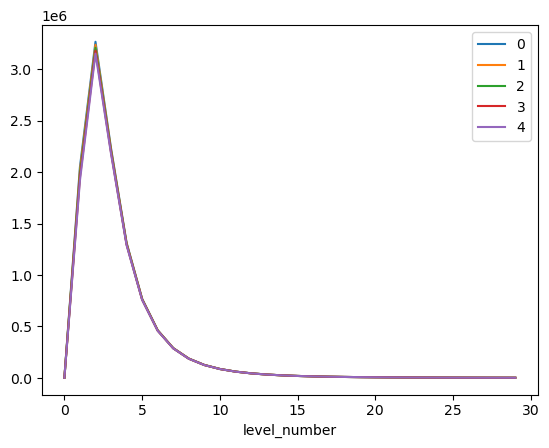

In [12]:
spontaneous_recombination_rate_old.loc[1,0,:].plot()

<Axes: xlabel='level_number'>

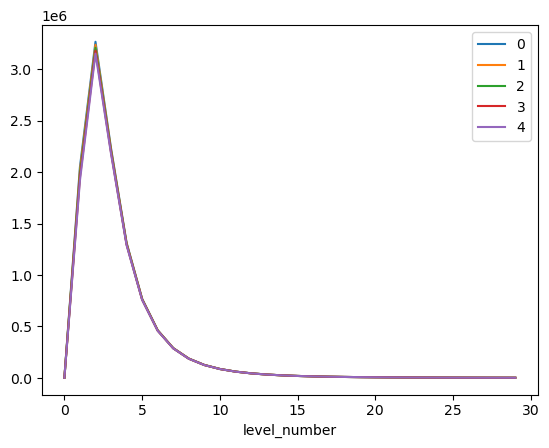

In [13]:
spontaneous_recombination_rate.loc[1,0,:].plot()

In [16]:
from tardis.plasma.equilibrium.level_populations import LevelPopulationSolver
from tardis.plasma.equilibrium.rate_matrix import RateMatrix

rate_matrix_solver = RateMatrix(rate_solvers, cmfgen_atom_data.levels)

rate_matrix = rate_matrix_solver.solve(rad_field, electron_dist)

lte_rate_matrix = RateMatrix(lte_rate_solvers, cmfgen_atom_data.levels).solve(rad_field, electron_dist)

In [ ]:
solver = LevelPopulationSolver(rate_matrix, cmfgen_atom_data.levels)

level_pops = solver.solve()

lte_level_pops = LevelPopulationSolver(lte_rate_matrix, cmfgen_atom_data.levels).solve()

In [ ]:
plt.scatter(cmfgen_atom_data.levels.loc[1,0].energy * u.erg.to('eV'), level_pops.loc[1,0,:][0], marker='x', label='TARDIS')
plt.scatter(cmfgen_atom_data.levels.loc[1,0].energy * u.erg.to('eV'), lte_level_pops.loc[1,0,:][0], marker='x', label='TARDIS col only')
plt.xlabel("Energy (eV)")
plt.ylabel("Population")
plt.semilogy()
plt.legend()